Dataset Loaded: (319795, 18)
AI Responses Loaded: (494, 7)


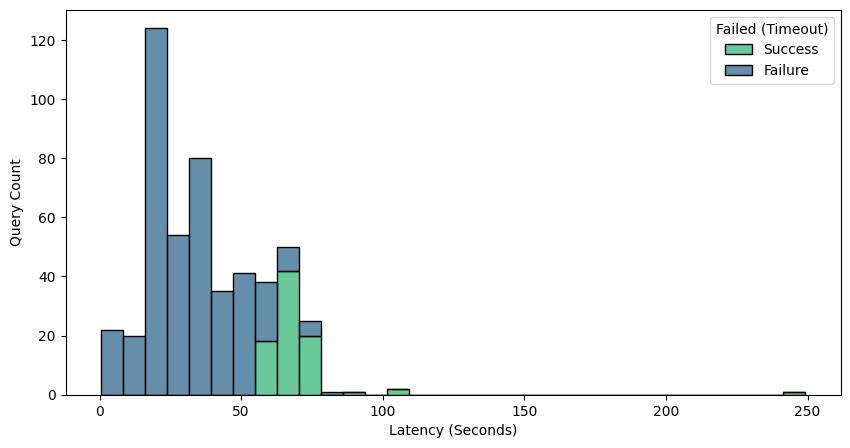

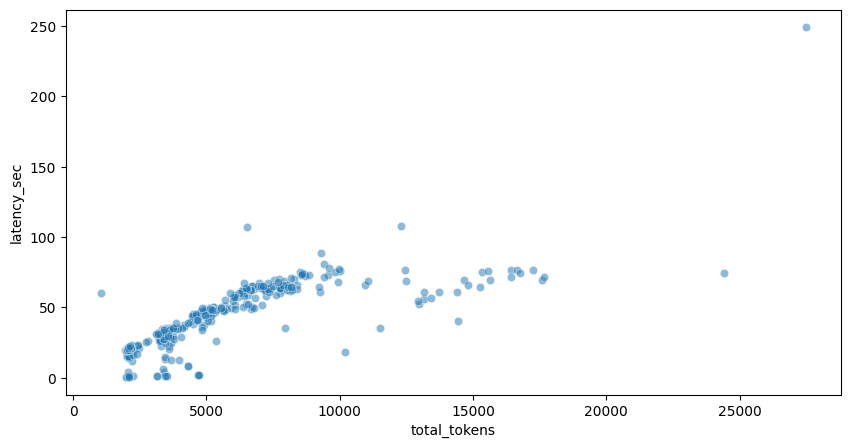

--- MANUSCRIPT STATISTICS ---
Overall System Success Rate: 83.00%
Average Processing Speed: 30.07 TPS
Average Latency: 38.01 seconds


In [ ]:
# --- SECTION 1: SETUP & DATA LOADING ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from difflib import SequenceMatcher

# Load the primary dataset
df = pd.read_csv("/content/heart_2020_cleaned.csv")

# Load your AI Agent logs
logs = pd.read_csv("/content/journal_research_metrics.csv")

# Pre-process binary columns to match your Agent's environment
binary_cols = ['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking',
               'Diabetic', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

print(f"Dataset Loaded: {df.shape}")
print(f"AI Responses Loaded: {logs.shape}")

# --- SECTION 2: GROUND TRUTH ENGINE ---
# This dictionary maps specific query keywords to ground truth logic.
# In a real paper, you would verify a subset of 50-100 queries manually.

def calculate_ground_truth(query):
    """
    Programmatic ground truth for common descriptive queries.
    """
    query = query.lower()
    try:
        if "overall percentage of heart disease" in query:
            return round(df['HeartDisease'].mean() * 100, 2)

        if "average bmi" in query and "all respondents" in query:
            return round(df['BMI'].mean(), 2)

        if "smokers" in query and "how many" in query:
            # Check if user asked for percentage or count
            return round((df['Smoking'] == 1).mean() * 100, 2)

        if "sleeptime" in query and "mean" in query:
            return round(df['SleepTime'].mean(), 2)

        return "Manual Verification Required"
    except Exception as e:
        return f"Error: {e}"

# --- SECTION 3: VALIDATION ANALYSIS ---

def check_accuracy(row):
    gt = calculate_ground_truth(row['user_query'])
    if gt == "Manual Verification Required":
        return "TBD"

    # Simple numeric comparison (allowing for small float differences)
    try:
        llm_val = float(str(row['llm_response']).strip())
        return 1 if abs(llm_val - gt) < 0.1 else 0
    except:
        return 0

# Apply validation
logs['ground_truth'] = logs['user_query'].apply(calculate_ground_truth)
logs['is_accurate'] = logs.apply(check_accuracy, axis=1)

# --- SECTION 4: JOURNAL VISUALIZATIONS ---

# 1. Latency vs. Success Rate
plt.figure(figsize=(10, 5))
sns.histplot(data=logs, x="latency_sec", hue=logs['llm_response'].str.contains("Agent stopped"),
             multiple="stack", palette="viridis")
plt.xlabel("Latency (Seconds)")
plt.ylabel("Query Count")
plt.legend(title="Failed (Timeout)", labels=["Success", "Failure"])
plt.show()

# 2. Token Efficiency (TPS)
plt.figure(figsize=(10, 5))
sns.scatterplot(data=logs, x="total_tokens", y="latency_sec", alpha=0.5)
plt.show()

# --- SECTION 5: STATISTICAL SUMMARY FOR PAPER ---
success_rate = (logs[~logs['llm_response'].str.contains("Agent stopped", na=False)].shape[0] / len(logs)) * 100
avg_tps = logs['tps'].mean()

print("--- MANUSCRIPT STATISTICS ---")
print(f"Overall System Success Rate: {success_rate:.2f}%")
print(f"Average Processing Speed: {avg_tps:.2f} TPS")
print(f"Average Latency: {logs['latency_sec'].mean():.2f} seconds")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataset shape: (319795, 19)
Agent logs: (494, 7)

Baseline Query Coverage: 8.50%

--- COMPARATIVE RESULTS ---
Agent Success Rate: 83.00%
Baseline Success Rate: 8.50%
Baseline Coverage: 8.50%
Agent Mean Latency: 38.01 sec
Agent Median Latency: 33.03 sec
Baseline Mean Latency: 0.0013 sec
Baseline Median Latency: 0.0012 sec
Baseline Accuracy (where measurable): 95.24%


/tmp/ipython-input-2468233796.py:200: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


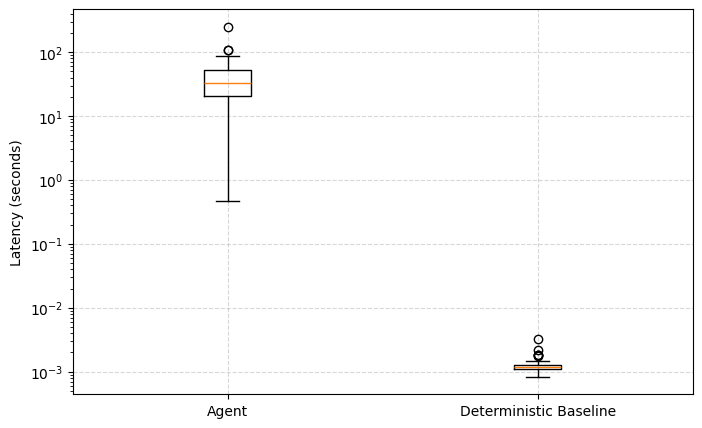

In [ ]:
# ============================================================
# BASELINE COMPARISON: AGENT vs DETERMINISTIC PANDAS EXECUTION
# ============================================================

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# SECTION 1: LOAD DATA
# ------------------------------------------------------------

# Load dataset
df = pd.read_csv("/content/heart_2020_cleaned.csv")

# Load agent logs
logs = pd.read_csv("/content/journal_research_metrics.csv")

# -------- FIXED BINARY PREPROCESSING (IMPORTANT) ----------
# REMOVE Diabetic from Yes/No mapping (it is NOT binary)
binary_cols = [
    'HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke',
    'DiffWalking', 'PhysicalActivity',
    'Asthma', 'KidneyDisease', 'SkinCancer'
]

for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

# Optional: create a clean binary Diabetic variable
df['Diabetic_binary'] = df['Diabetic'].apply(lambda x: 1 if "Yes" in str(x) else 0)

print(f"Dataset shape: {df.shape}")
print(f"Agent logs: {logs.shape}")

# ------------------------------------------------------------
# SECTION 2: GROUND TRUTH ENGINE (EXPANDED)
# ------------------------------------------------------------

def calculate_ground_truth(query):
    q = query.lower()

    try:
        if "overall percentage of heart disease" in q:
            return round(df['HeartDisease'].mean() * 100, 2)

        if "average bmi" in q:
            return round(df['BMI'].mean(), 2)

        if "how many" in q and "smoker" in q:
            return int((df['Smoking'] == 1).sum())

        if "percentage" in q and "smoker" in q:
            return round((df['Smoking'] == 1).mean() * 100, 2)

        if "mean" in q and "sleeptime" in q:
            return round(df['SleepTime'].mean(), 2)

        if "how many people have heart disease" in q:
            return int(df['HeartDisease'].sum())

        if "average mental health" in q:
            return round(df['MentalHealth'].mean(), 2)

        return "Manual Verification Required"

    except Exception as e:
        return f"Error: {e}"

# ------------------------------------------------------------
# SECTION 3: LIGHTWEIGHT BASELINE (NO AGENT, NO LLM)
# ------------------------------------------------------------

def baseline_execute(query):
    q = query.lower()

    try:
        start = time.perf_counter()

        if "overall percentage of heart disease" in q:
            output = round(df['HeartDisease'].mean() * 100, 2)

        elif "average bmi" in q:
            output = round(df['BMI'].mean(), 2)

        elif "how many" in q and "smoker" in q:
            output = int((df['Smoking'] == 1).sum())

        elif "percentage" in q and "smoker" in q:
            output = round((df['Smoking'] == 1).mean() * 100, 2)

        elif "mean" in q and "sleeptime" in q:
            output = round(df['SleepTime'].mean(), 2)

        elif "how many people have heart disease" in q:
            output = int(df['HeartDisease'].sum())

        elif "average mental health" in q:
            output = round(df['MentalHealth'].mean(), 2)

        else:
            return {
                "status": "unsupported",
                "latency": None,
                "output": None
            }

        latency = time.perf_counter() - start

        return {
            "status": "success",
            "latency": latency,
            "output": output
        }

    except Exception as e:
        return {
            "status": "error",
            "latency": None,
            "output": str(e)
        }

# ------------------------------------------------------------
# SECTION 4: RUN BASELINE ON SAME QUERIES
# ------------------------------------------------------------

baseline_results = []

for _, row in logs.iterrows():
    res = baseline_execute(row['user_query'])

    baseline_results.append({
        "user_query": row['user_query'],
        "baseline_status": res["status"],
        "baseline_latency": res["latency"],
        "baseline_output": res["output"]
    })

baseline_df = pd.DataFrame(baseline_results)

# Report baseline coverage (important for paper)
baseline_coverage = (baseline_df['baseline_status'] == "success").mean() * 100
print(f"\nBaseline Query Coverage: {baseline_coverage:.2f}%")

# ------------------------------------------------------------
# SECTION 5: ACCURACY CHECK (WHERE POSSIBLE)
# ------------------------------------------------------------

def baseline_accuracy(row):
    if row['baseline_status'] != "success":
        return None

    gt = calculate_ground_truth(row['user_query'])
    if gt == "Manual Verification Required":
        return None

    try:
        return abs(float(row['baseline_output']) - gt) < 0.01
    except:
        return False

baseline_df['is_accurate'] = baseline_df.apply(baseline_accuracy, axis=1)

# ------------------------------------------------------------
# SECTION 6: AGENT vs BASELINE COMPARISON
# ------------------------------------------------------------

# Agent success = completed without timeout
agent_valid = ~logs['llm_response'].str.contains("Agent stopped", na=False)
agent_success_rate = agent_valid.mean() * 100

baseline_success_rate = (
    baseline_df['baseline_status'] == "success"
).mean() * 100

agent_mean_latency = logs['latency_sec'].mean()
agent_median_latency = logs['latency_sec'].median()

baseline_mean_latency = baseline_df['baseline_latency'].dropna().mean()
baseline_median_latency = baseline_df['baseline_latency'].dropna().median()

baseline_accuracy_rate = baseline_df['is_accurate'].mean() * 100

print("\n--- COMPARATIVE RESULTS ---")
print(f"Agent Success Rate: {agent_success_rate:.2f}%")
print(f"Baseline Success Rate: {baseline_success_rate:.2f}%")
print(f"Baseline Coverage: {baseline_coverage:.2f}%")
print(f"Agent Mean Latency: {agent_mean_latency:.2f} sec")
print(f"Agent Median Latency: {agent_median_latency:.2f} sec")
print(f"Baseline Mean Latency: {baseline_mean_latency:.4f} sec")
print(f"Baseline Median Latency: {baseline_median_latency:.4f} sec")
print(f"Baseline Accuracy (where measurable): {baseline_accuracy_rate:.2f}%")

# ------------------------------------------------------------
# SECTION 7: JOURNAL-READY VISUALIZATION
# ------------------------------------------------------------

plt.figure(figsize=(8, 5))
plt.boxplot(
    [
        logs['latency_sec'].dropna(),
        baseline_df['baseline_latency'].dropna()
    ],
    labels=["Agent", "Deterministic Baseline"]
)
plt.ylabel("Latency (seconds)")
plt.yscale("log")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()
